In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install kneed

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u412-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Row, types as T
from pyspark.sql.functions import col, split, regexp_replace, collect_list, hash as spark_hash, concat_ws, when, abs, explode, desc, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, LongType, DoubleType, IntegerType
from pyspark.sql.functions import udf
import numpy as np
from collections import Counter
from random import shuffle
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinHashLSH
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
def create_session():
    # create the session
    conf = SparkConf()
    conf.setAppName("DIS-lab-1")    # Sets name of the Spark Application
    conf.setMaster("local[16]")    # Master URL. In this case local[*] uses all the available cores in the machine
    conf.set("spark.driver.memory", "10G")   # Memory allocated to driver process
    conf.set("spark.driver.maxResultSize", "6G")    # Maximum size of results that can be returned to driver
    conf.set("spark.executor.instances", "4")
    conf.set("spark.executor.cores", "4")
    conf.set("spark.executor.memory", "4G")    # Memory allocated to each executor
    conf.set("spark.network.timeout", "600s")  # Increase network timeout
    conf.set("spark.executor.heartbeatInterval", "60s")  # Increase heartbeat interval
    conf.set("spark.rpc.message.maxSize", "512")  # Increase max message size
    conf.set("spark.driver.maxResultSize", "4G")  # Increase driver max result size
    conf.set("spark.sql.broadcastTimeout", "600")  # Increase broadcast timeout
    conf.set("spark.sql.shuffle.partitions", "200")  # Increase the number of shuffle partitions
    conf.set("spark.yarn.executor.memoryOverhead", "2048")  # Increase memory overhead
    conf.set("spark.memory.offHeap.enabled","true")
    conf.set("spark.memory.offHeap.size","10g")
    conf.set("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12")  # Add GraphFrames to the spark configuration
    conf.set("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem")  # Ensure local file system is used for checkpointing

    sc = pyspark.SparkContext(conf=conf)    # Initializes the Spark context with this specific configuration
    spark = SparkSession.builder.config(conf=sc.getConf()).getOrCreate()    # Creates Spark session

    # Set checkpoint directory
    sc.setCheckpointDir("checkpoints")

    return sc, spark

try:
    if 'sc' in globals() and sc is not None:
        sc.stop()
        print("--Stopped existing SparkContext")
    if 'spark' in globals() and isinstance(spark, SparkSession):
        spark.stop()
        print("--Stopped existing SparkSession")
except Exception as e:
    print(f"Error stopping existing Spark session or context: {e}")

# Create a new Spark session
sc, spark = create_session()
print("Spark session created successfully!")
spark

Spark session created successfully!


In [4]:
logs = spark.read.csv('final_after_removl.csv', header=True, inferSchema=True)
logs = logs.dropDuplicates(['process_id'])

In [5]:
logs.limit(5).show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Split the from_servers string by comma and trim spaces
logs = logs.withColumn('servers_list', F.split(F.trim(logs['from_servers']), ',\s*'))

# Get unique server names
unique_servers = logs.select(F.explode('servers_list').alias('server')).distinct()

# Pivot to create one-hot encoded columns
logs = logs.join(unique_servers, F.array_contains(logs['servers_list'], unique_servers['server']), 'left_outer') \
           .groupBy(logs.columns) \
           .pivot('server') \
           .agg(F.lit(1).alias('dummy')) \
           .na.fill(0)

In [7]:
logs.limit(5).show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
# Split the times column, convert to integer and sum the values
logs = logs.withColumn("sum_times",
    F.expr("aggregate(transform(split(times, ','), x -> int(trim(x))), 0, (acc, x) -> acc + x)")
)

In [9]:
logs.limit(5).show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Keep extracted features
final_logs = logs.drop(*['servers_list', 'from_servers', 'to_servers', 'times', 'actions'])
final_logs.limit(5).show(truncate=False)

+----------+------------+------------+------------+---------------------------+-------------------------+-------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------+---------------------+-------------------+--------------------+-------------------+-------------------+-------------------+----------------------------+----------------------------+--------------------------------+-------------------------+-----------------+-----------------+-------------------------+---------------------------+---------------------------+-------------------------------+-------------------------+------------------+-------------------------+--------------------------+--------------------------+--------------------------+-------------------------+--------------------------+-------------------+----------------------+-----------------------+----------------------+--------------------

Search for k: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
The optimal number of clusters is: 5


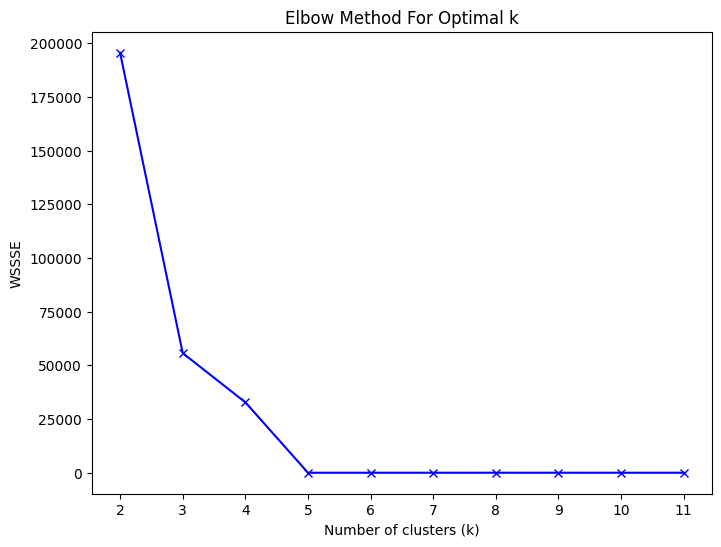

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator

# Select columns for input features
cols_except_process_id = [col for col in final_logs.columns if col != 'process_id']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=cols_except_process_id, outputCol='features')
feature_logs = assembler.transform(final_logs)

# Initialize an empty list to store WSSSE values for different k
wssse_values = []

# Define the range of k values to test
batch_size = 10
min_k = 2
max_k = final_logs.count()
# Ensure batch size of k for correct elbow method results
k_values = list(range(min_k, max(max_k + 1, min_k + batch_size)))
print(f'Search for k: {k_values}')

# Function to run the clustering in batches
def run_batches(k_values, batch_size):
    previous_optimal_k = None
    while k_values:
        batch_k = k_values[:batch_size]
        k_values = k_values[batch_size:]

        for k in batch_k:
            kmeans = BisectingKMeans(k=k, seed=123)
            model = kmeans.fit(feature_logs)
            wssse = model.summary.trainingCost
            wssse_values.append((k, wssse))

        # Extract K and WSSSE values
        k_vals, wssse_vals = zip(*wssse_values)

        # Use the Kneedle algorithm to find the elbow point
        kneedle = KneeLocator(k_vals, wssse_vals, curve='convex', direction='decreasing')
        optimal_k = kneedle.knee

        if optimal_k == previous_optimal_k:
            break
        previous_optimal_k = optimal_k

    return optimal_k, k_vals, wssse_vals

# Run the clustering in batches
optimal_k, k_vals, wssse_vals = run_batches(k_values, batch_size)
print(f'The optimal number of clusters is: {optimal_k}')

# Plot the WSSSE values against the k values to find the elbow point
plt.figure(figsize=(8, 6))
plt.plot(k_vals, wssse_vals, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.xticks(k_vals)
plt.ylabel('WSSSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [12]:
# Train the final model using the optimal k
kmeans = BisectingKMeans(k=optimal_k, seed=123)
model = kmeans.fit(feature_logs)

# Make predictions
predictions = model.transform(feature_logs)

# Show cluster centers
"""
print("Cluster Centers:")
centers = model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx}: {center}")
"""

# Show predictions
predictions.select("process_id", "prediction").show()

+----------+----------+
|process_id|prediction|
+----------+----------+
|         1|         2|
|         6|         1|
|        12|         3|
|        16|         0|
|        22|         4|
+----------+----------+

